# Model inference using Homomorphic Encryption (CKKS)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from src.classifier import MnistClassifier
from src.ckks import CkksCompatibleMnistClassifier, Encryptor

torch.manual_seed(42)

## Load a subset of the validation set

In [3]:
dataset = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
dataset = [elem for idx, elem in enumerate(dataset) if idx < 30000]
print(f"Dataset size: {len(dataset)}")
print(f"Input image shape: {dataset[0][0].shape}")

Dataset size: 30000
Input image shape: torch.Size([1, 28, 28])


In [4]:
train_split_idx = len(dataset) * 3 // 4
_, valid_ds = torch.utils.data.random_split(dataset, [train_split_idx, len(dataset) - train_split_idx])
print(f"Validation dataset size: {len(valid_ds)}")
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=1, shuffle=False)
print(f"Validation dataloader size: {len(valid_dl)}")

Validation dataset size: 7500
Validation dataloader size: 7500


## Load the model and its CKKS alternative

In [5]:
model = MnistClassifier()
model.load_state_dict(torch.load("models/mnist_classifier.pth", weights_only=True))
model.eval()
ckks_model = CkksCompatibleMnistClassifier(model)
encryptor = Encryptor()

## Display the metrics of the CKKS inference

100%|██████████| 500/500 [28:24<00:00,  3.41s/it]

Accuracy: 0.9580
Precision: 0.9593
Recall: 0.9580
F1 Score: 0.9580


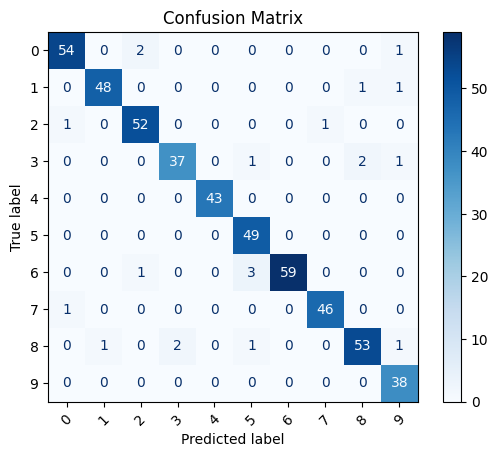

In [6]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
)

model.eval()

all_labels = []
all_preds = []
max_iter = 500

with torch.no_grad():
    for idx, (images, labels) in tqdm.tqdm(enumerate(valid_dl), total=max_iter):
        if idx == max_iter:
            break

        enc_images = encryptor.encrypt_image(images)
        enc_outputs = ckks_model(enc_images)
        outputs = torch.tensor(encryptor.decrypt(enc_outputs)).unsqueeze(dim=0)
        
        _, predictions = torch.max(outputs, dim=1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predictions.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()